# Predicting pneumonia from X-ray image: Checkpoint #2

Members: 
- Claire Boyd
- Jack Gibson
- Benjamin Leiva
- Raul Castellanos

## Identify relevant classifier accuracy metrics

As we saw in Checkpoint #1, the distribution of labels in our dataset is skewed, consisting of 7,750 positively labeled images (chest x-rays with pneumonia detected) and 2,682 negatively labeled images  (chest x-rays with no pneumonia detected). This means that the majority prediction accuracy rate of the whole dataset would be 74.3% if we always predicted pneumonia for all images. Since the proportion of normal images in our data is much smaller (25.7%), our model will likely do better predicting pneumonia than normal images given that it will be the “default” prediction.

Acknowledging the fact that we usually incline heavily towards preventing false negatives in the healthcare context, given the skewed distribution of labels in our dataset we decided to focus on correctly predicting 'normal' x-rays rather than 'pneumonia' ones.

In terms of possible combinations of actual vs predicted values, we'll focus on maximizing true negatives, i.e., 'normal' predicted x-rays that don't actually have pneumonia:

| |  Actual Positive (Pneumonia)| Actual Negative (Normal) |
|--|--|--|
| **Predicted Positive (Pneumonia)**| True Positives   | False Positives |
| **Predicted Negative (Normal)**   |  False Negatives | **TRUE NEGATIVES**|
|Total|7,750 | 2,682 |

This translates into using the following accuracy metric as guidance:

$ \text{Metric \#1: } \quad \frac{ \text{Correctly Predicted Normal}}{ \text{All Normals}} = \frac{ \text{True negatives}}{ \text{True negatives + False positives}} = \frac{ \text{True negatives}}{2,682}$

Since we are focusing on the minority label, we can also use the F1 metric to evaluate accuracy. Using True Positives (TP), False Positives (FP), and False Negatives (FN), we can define it as: 

$\text{F1} = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$ ;  with $\text{precision} = TP/(TP+FP)$ and $\text{recall} = TP/(TP+FN)$.

## Building the custom Neural Network

In this section we build and run our NN. It consists of the following steps:

0. Import the required packages for training our model, using Pytorch's modules as well as classes from our data module.

1. We load our x-rays using the CustomImageDataset class, which takes each instance's information from previously manufactured csv files and applies three transformations/filters on each image: CenterCrop (zooms in on central area of x-ray, croping non-relevant regions like arms and shoulders), Resize (makes every image have the same size), and GrayScale (converts colors in x-ray to a single gray scale, making it easier to identify pneumonia regions). We do this for training, validation and testing data separately.

2. By dataset type, we grouped and shuffled the transformed x-rays (now centered and homogenous in size and color) into batches for analysis. 

3. Build and train our model by defining training and validation datasets, as well as hyperparameters 'epoch' (total epochs to run) and 'epoch_step' (threshold for storing performance metrics). For the purposes of this checkpoint's requirements we set them to be 15 and 1 respectively, in order to have a relatively short running time and enough metrics data to see how effective our model is.

In [13]:
# Import modules
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from process.model import CustomNeuralNetwork   #internal
from process.data_module import CustomImageDataset, transforms  #internal

In [9]:
# Load original x-rays and apply transformations
training_data = CustomImageDataset("data/output/train.csv", "data/train/", transforms)
val_data = CustomImageDataset("data/output/val.csv", "data/val/", transforms)
test_data = CustomImageDataset("data/output/test.csv", "data/test/", transforms)

# Load groups/batches of x-rays for analysis
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
# Build and train model
model = CustomNeuralNetwork()
train_list, val_list = model.train_model(train_dataloader, val_dataloader, epochs=15, epoch_step=1)

NameError: name 'CustomNeuralNetwork' is not defined

## Initial analysis of custom model

In this section we evaluate the performance of our neural network model. We start by building a confusion matrix as the one described at the beggining of this notebook:

In [8]:
# Confusion matrix
model.confusion_matrix

array([[1306,   35],
       [   5, 3870]])

where we see the following results for our last epoch:

- True positives: 1,306
- False positives: 35
- False negatives: 5
- True negatives:  3,870

Using these as inputs for our accuracy metrics of interest:

Metric #1:

$$
\quad \frac{ \text{True negatives}}{ \text{True negatives + False positives}} = \frac{3,870}{3,870 + 35} = \frac{3,870}{3,905} = 99.1\%
$$

Metric #2:

$$
\quad \text{Precision} = \frac{TP}{TP+FP} = \frac{1,306}{1,306+35} = 97.4\% \quad \text{;} \quad \text{Recall} = \frac{TP}{TP+FN} = \frac{1,306}{1,306+5} = 99.6\%
$$
$$
\quad \text{F1} = 2\frac{\text{precision} \cdot \text{recall}}{\text{precision + recall}} = 2 \frac{(0.974 * 0.996)}{(0.974 + 0.996)} = 2 \frac{0.97}{1.97} = 2 * 0.492 = 98.5\%
$$

Inital Test (5 epochs):

Running time: 22 minutes

Baseline accuracy: 0.5032051282051282 (313/624)

Recall: 0.7083333333333334

Splits: 192 positive predictions (pneumonia), 432 negative predictions (normal)

Now, we'll analyse the evolution of our recall and accuracy metrics as we go through our data. 

In [6]:
# Store metrics by data type 
train_losses, train_accuracies, train_recalls = train_list
val_losses, val_accuracies, val_recalls = val_list

# Show results
print('Training data:', "\nLosses: ", train_losses, "\nAccuracies: ", train_accuracies, "\nRecalls: ", train_recalls)
print('\n', 'Validation data:', "\nLosses: ", val_losses, "\nAccuracies: ", val_accuracies, "\nRecalls: ", val_recalls)

train_losses:  [0.30065682975620756, 0.24651414128701862, 0.17771756081137716, 0.15636538541535053, 0.10940450366313864, 0.09466524248397569, 0.06221734055476945, 0.057469665805423044, 0.08387218277458465, 0.04886196016493004, 0.04911814055621352, 0.04608139631383848, 0.03368747568825578, 0.03236793590391555, 0.032142275262896605]
train_accuracies:  [0.8755751533742331, 0.9072085889570553, 0.9403757668711656, 0.9488113496932515, 0.9683665644171779, 0.9710506134969326, 0.9842791411042945, 0.9848542944785276, 0.9756518404907976, 0.9877300613496932, 0.9861963190184049, 0.9894555214723927, 0.9927147239263804, 0.9923312883435583, 0.9923312883435583]
train_recalls:  [0.7099179716629381, 0.8337061894108874, 0.901565995525727, 0.9097688292319165, 0.947800149142431, 0.9500372856077554, 0.9634601043997018, 0.9619686800894854, 0.9351230425055929, 0.9671886651752424, 0.9604772557792692, 0.9701715137956749, 0.9739000745712155, 0.9739000745712155, 0.9739000745712155]
val_losses:  [4.130391597747803,

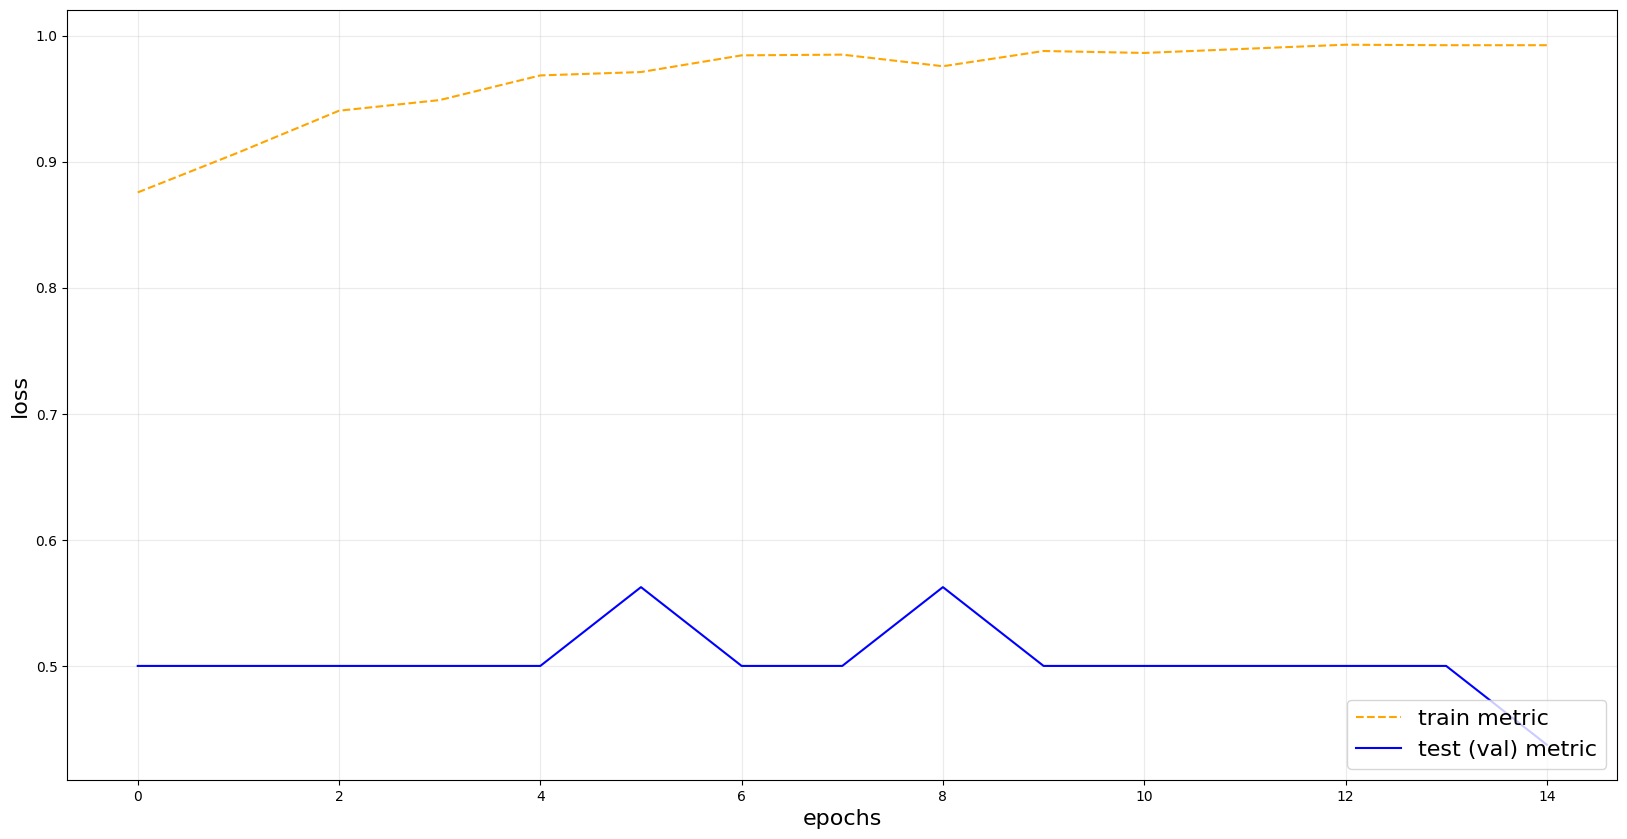

In [10]:
# Recall evolution
model.create_graph(15, 1, train_recalls, val_recalls)

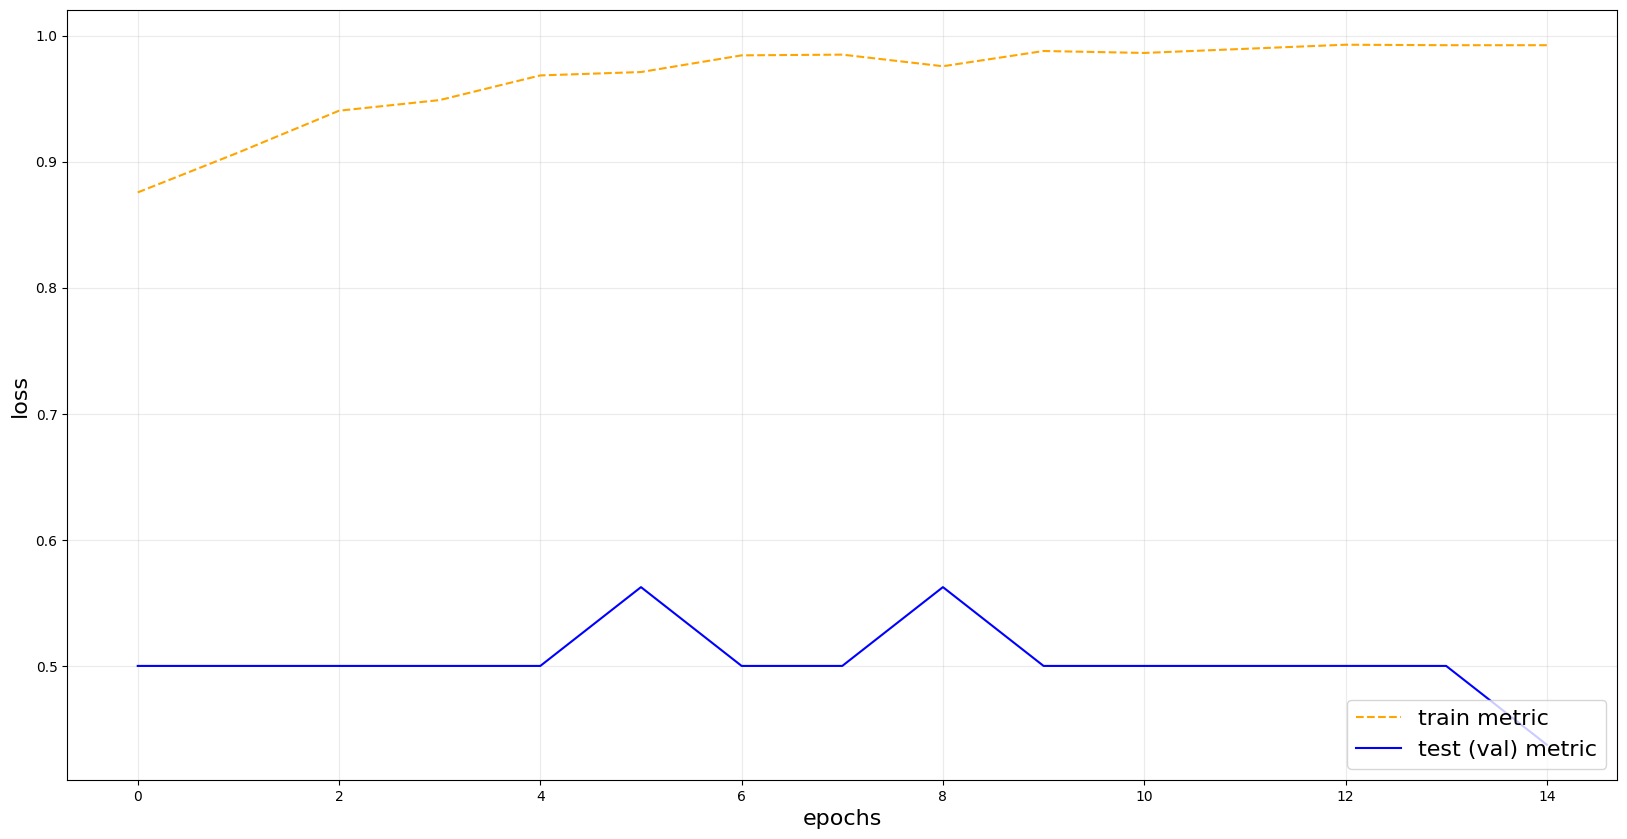

In [11]:
# Accuracy evolution
model.create_graph(15, 1, train_accuracies, val_accuracies)

In [ ]:
model2 = CustomNeuralNetwork()
train_list, val_list = model.train_model(train_dataloader, val_dataloader, epochs=15, epoch_step=1)

Test 2: Smaller images size (256, 256); 15 epochs

Train Acc Range (epoch 0 - 14): 0.8500766871165644 - 0.9806365030674846

Last Train Recall Range: 0.717509727626459 - 0.9711246200607903

Test Acc: 0.625

Test recall: 0.00 ???

In [ ]:
# testing sklearn recall 
from sklearn.metrics import recall_score

y_pred = torch.tensor([1, 0, 1, 0])
y_true = torch.tensor([1, 0, 0, 0])

recall_score(y_true, y_pred)
y_true = torch.cat((y_pred, y_true))